In [636]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Preparation

In [637]:
df = pd.read_csv('../01-intro/laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [638]:
for col in df.columns:
    if col not in ['ram', 'storage', 'screen', 'final_price']:
        df.drop(columns=col, inplace=True)
        
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [639]:
# df.screen.describe()

In [640]:
# df.screen.fillna(15.6, inplace=True)
# df.fillna({ "screen": 15.6 }, inplace=True)
# df.isnull().sum()

## Exploritory Data Analysis

<Axes: xlabel='final_price', ylabel='Count'>

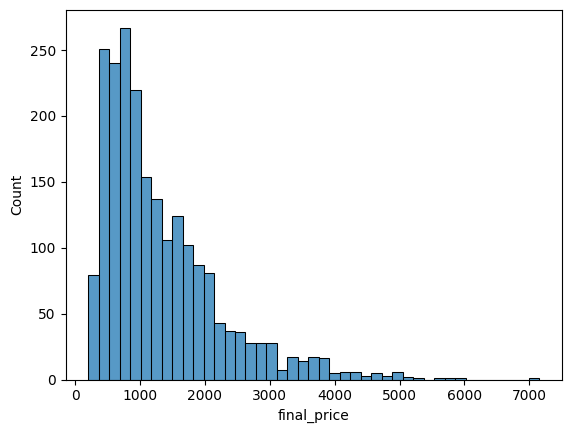

In [641]:
sns.histplot(df.final_price)

As `final_price`, the target feature, has a 'long tail' / is not a normal distribution, it needs to be engineered. Here, using logarithmic scaling.

### Question 1
There's one column with [values missing]. [Which] is it?

* `'screen'`

Albeit already corrected in the Preparation phase above.

### Question 2

What's the median (50% percentile) [value] for variable `'ram'`?

In [642]:
df.ram.describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

- 16

## Preparation for Linear Regression

### Categorical features

TBC

### Apply Logarithmic Scaling to `final_price`

In [643]:
np.log1p([0.1, 0, 1, 10, 100, 1000, 10000, 100000, 1000000])

array([ 0.09531018,  0.        ,  0.69314718,  2.39789527,  4.61512052,
        6.90875478,  9.21044037, 11.51293546, 13.81551156])

In [644]:
df['log_final_price'] = np.log1p(df.final_price)
df.head()

,ram,storage,screen,final_price,log_final_price
0,8,512,15.6,1009.00,6.917706
1,8,256,15.6,299.00,5.703782
2,8,256,15.6,789.00,6.672033
3,16,1000,15.6,1199.00,7.090077
4,16,512,15.6,669.01,6.507293


<Axes: xlabel='log_final_price', ylabel='Count'>

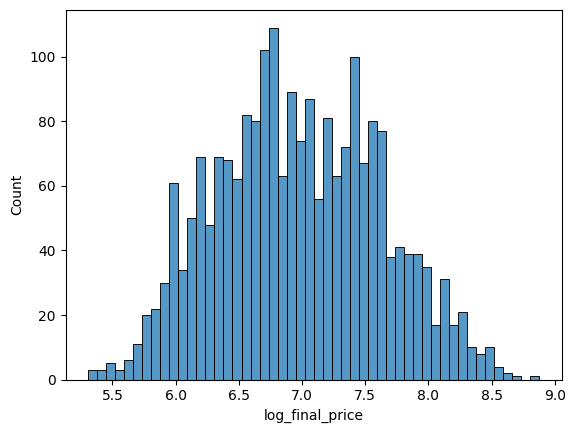

In [645]:
sns.histplot(df.log_final_price, bins=50)

In [646]:
#del df['final_price']
df.head()

,ram,storage,screen,final_price,log_final_price
0,8,512,15.6,1009.00,6.917706
1,8,256,15.6,299.00,5.703782
2,8,256,15.6,789.00,6.672033
3,16,1000,15.6,1199.00,7.090077
4,16,512,15.6,669.01,6.507293


### Randomly shuffle the observations

In [647]:
row_indices = np.arange(df.shape[0])
assert len(row_indices) == df.shape[0]

np.random.seed(42)
np.random.shuffle(row_indices)

row_indices

array([2079,  668, 2073, ..., 1130, 1294,  860])

### Split the data for Linear Regression

- Validation: 20%
- Testing: 20%
- Training: what remains ¬60%

In [648]:
def split_for_linear_regression(dataframe, seed = 42, validation = 0.2, testing = 0.2):
    assert 0 < validation and 0 < testing and 1 > (validation + testing)
    
    df = dataframe.copy()
    
    row_indices = np.arange(df.shape[0])
    n_rows = len(row_indices)
    assert n_rows == df.shape[0]

    np.random.seed(int(seed))
    np.random.shuffle(row_indices)
        
    n_validation = int(validation * n_rows)
    n_testing = int(testing * n_rows)
    
    df_validation = df.iloc[ row_indices[ : n_validation ] ]
    df_testing = df.iloc[ row_indices[ n_validation : n_validation + n_testing ] ]
    df_training = df.iloc[ row_indices[ n_validation + n_testing : ] ]

    assert n_rows == df_validation.shape[0] + df_testing.shape[0] + df_training.shape[0]

    df_validation = df_validation.reset_index(drop=True)
    df_testing = df_testing.reset_index(drop=True)
    df_training = df_training.reset_index(drop=True)

    return df_validation, df_testing, df_training

In [649]:
df_validation, df_testing, df_training = split_for_linear_regression(df)

n_rows = df.shape[0]
n_validation = df_validation.shape[0]
n_testing = df_testing.shape[0]
n_training = df_training.shape[0]

n_validation, round(n_validation / n_rows, 1), n_testing, round(n_testing / n_rows, 1), n_training, round(n_training / n_rows, 1), n_rows

(432, 0.2, 432, 0.2, 1296, 0.6, 2160)

## Linear Regression

### Long form / Algebraic

In [650]:
xi = [453,   11,    86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

def predict_with_linear_regression_longform(xi):
    assert len(xi) == len(w)
    prediction = w0
    
    for f in range(len(xi)): 
        #bias term (w0) + SUM OF feature * weighting
        prediction = prediction + xi[f] * w[f]
        
    return w0, np.expm1(prediction)

w0, wi = predict_with_linear_regression_longform(xi)
w0, wi

(7.17, 222347.2221101062)

### Vector form

In [651]:
def dot(xi, w):
    assert len(xi) == len(w)
    product = 0.0
    
    for j in range(len(xi)): 
        product = product + xi[j] * w[j]
        
    return product

def predict_with_linear_regression_vectorform(xi, w):
    assert len(xi) == len(w) and 0 < len(w)
    return w[0], np.expm1( dot(xi, w) )

predict_with_linear_regression_vectorform(xi=[1] + xi, w=[w0] + w)

(7.17, 222347.2221101062)

### Matrix form

In [652]:
x1 = [1, 148, 24, 1385]
x2 = [1, 132, 25, 2031]
x3 = [1, 453, 11,   86]

X = np.array([x1, x2, x3])
X

array([[   1,  148,   24, 1385],
       [   1,  132,   25, 2031],
       [   1,  453,   11,   86]])

In [653]:
X.dot([w0] + w)

array([12.38 , 13.552, 12.312])

In [654]:
def predict_with_linear_regression(X, w):
    assert 0 < len(X) and len(X[0]) == len(w) and 0 < len(w)
    
    products = X.dot(w)
    #return products
    predictions = []
    
    for p in products:
        predictions = predictions + [ np.expm1(p) ]
    
    return w[0], predictions

predict_with_linear_regression(X, w=[w0] + w)

(7.17, [237992.82334859075, 768348.5101897252, 222347.22211010658])

## Training a LR model / Finding the weights (`w`) vector

- The Gram Matrix (`XtX`) has an Inverse (`X-1`)
- `w = (XtX)-1.Xt.y`

In [655]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11,   86],
    [158, 24,  185],
    [172, 25,  201],
    [413, 11,   86],
    [ 38, 54,  185],
    [142, 25,  431],
    [453, 31,   86],
]

X = np.array(X)
X

array([[ 148,   24, 1385],
       [ 132,   25, 2031],
       [ 453,   11,   86],
       [ 158,   24,  185],
       [ 172,   25,  201],
       [ 413,   11,   86],
       [  38,   54,  185],
       [ 142,   25,  431],
       [ 453,   31,   86]])

In [656]:
XTX = X.T.dot(X) # gram matrix
XTX

array([[ 696471,   44115,  718540],
       [  44115,    7146,  118803],
       [ 718540,  118803, 6359986]])

In [657]:
XTX_inverse = np.linalg.inv(XTX)

XTX.dot(XTX_inverse).round(1)

array([[ 1.,  0.,  0.],
       [-0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [658]:
def train_linear_regression(X, y):
    X = np.column_stack([ np.ones(X.shape[0]), X ])
    
    XTX = X.T.dot(X)
    XTX_inverse = np.linalg.inv(XTX)
    weights = XTX_inverse.dot(X.T).dot(y)
    
    return weights[0], weights[1:]

y = [ 100, 200, 150, 250, 100, 200, 150, 250, 120 ]

w0, w = train_linear_regression(X, y)
w0, w

(300.0677669255554, array([-0.22774253, -2.5769413 , -0.02301206]))

## Validating LR Models

### Root Mean Squared Error (RMSE)

In [659]:
def rmse(y, y_predicted):
    assert y.shape[0] == y_predicted.shape[0]
    
    error2 = (y - y_predicted) ** 2
    return np.sqrt( error2.mean() )
    
    error2 = 0.0
    for i in range(len(training)):
        error2 = error2 + np.square(training[i] - predicted[i])
    
    return np.sqrt( error2 / len(training) )

In [660]:
y_train = np.array([ 9, 9, 10.5, 11.5])
y_pred  = np.array([10, 9,   11,   10])

rmse(y_train, y_pred)

0.9354143466934853

### Regularization

Duplicate feature values give rise to the Inverse of XTX throwing an exception.

So we add a number (`r`) to the diagonal of the feature matrix to ensure the Inverse is generated.

Adding this `r` to the diagonal also affords adjustment of weights, thus allowing regularization of the prediction.

In [661]:
def regularize(X, r=0.000000001):
    return X + np.eye(X.shape[0]) * r

In [662]:
X = [
    [1, 2, 2],
    [2, 1, 1],
    [2, 1, 1]  
]

X = np.array(X)
X

array([[1, 2, 2],
       [2, 1, 1],
       [2, 1, 1]])

In [663]:
regularize(X, r=0.01)

array([[1.01, 2.  , 2.  ],
       [2.  , 1.01, 1.  ],
       [2.  , 1.  , 1.01]])

### Question 3

In [664]:
y_train = df_training['log_final_price']
del df_training['log_final_price']

In [665]:
df_training.isnull().sum()

ram            0
storage        0
screen         3
final_price    0
dtype: int64

In [666]:
df_training.screen.mean()

15.180974477958237

In [667]:
df_training_zero = df_training.fillna(             0             )
df_training_mean = df_training.fillna( df_training.screen.mean() )

zero_w0, zero_w = train_linear_regression(df_training_zero, y_train)
mean_w0, mean_w = train_linear_regression(df_training_mean, y_train)

y_pred_zero = zero_w0 + df_training_zero.dot( zero_w )
y_pred_mean = mean_w0 + df_training_mean.dot( mean_w )

rmse_zero = rmse(y_train, y_pred_zero)
rmse_mean = rmse(y_train, y_pred_mean)

round(rmse_zero, 2), round(rmse_mean, 2)

(0.23, 0.23)

- Both are equally good

### Question 4

In [668]:
def train_linear_regression(X, y, r=1):
    X = np.column_stack([ np.ones(X.shape[0]), X ])
    
    XTX = X.T.dot(X)
    if (r != 1):
        XTX = regularize(XTX, r)
    XTX_inverse = np.linalg.inv(XTX)
    weights = XTX_inverse.dot(X.T).dot(y)
    
    return weights[0], weights[1:]

In [669]:
tuning = []

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression(df_training_zero, y_train, r)
    y_pred_tuning = w0 + df_training_zero.dot(w)

    tuning = tuning + [[round(rmse(y_train, y_pred_tuning), 6), r]]
    
tuning    

[[0.22742, 0],
 [0.227421, 0.01],
 [0.227485, 0.1],
 [0.22742, 1],
 [0.292595, 5],
 [0.358243, 10],
 [0.554969, 100]]

- 0

### Question 5

In [670]:
tuning = []

for seed in range(10):
    df_validation, df_testing, df_training = split_for_linear_regression(df, seed, 0.2, 0.2)
    
    y_train = df_training['final_price']
    del df_training['final_price']
    del df_training['log_final_price']
    df_training_zero = df_training.fillna(0)
    
    w0, w = train_linear_regression(df_training_zero, y_train)
    
    y_validation = df_validation['final_price']
    del df_validation['final_price']
    del df_validation['log_final_price']
    df_validation_zero = df_validation.fillna(0)
    
    y_pred_tuning = w0 + df_validation_zero.dot(w)
    
    tuning = tuning + [round(rmse(y_validation, y_pred_tuning), 6)]
    
round(np.std(tuning), 3)

27.449

What's the NEAREST value of std?

- 29.176

### Question 6

In [671]:
df_validation, df_testing, df_training = split_for_linear_regression(df, 9, 0.2, 0.2)

df_training = pd.concat([df_training, df_validation])
y_training = df_training['log_final_price']
del df_training['final_price']
del df_training['log_final_price']
#df_training.head()

w0, w = train_linear_regression(df_training.fillna(0), y_training, r=0.001)
#w0, w

y_testing = df_testing['log_final_price']
del df_testing['log_final_price']
del df_testing['final_price']
#df_testing.head()

y_pred = w0 + df_testing.fillna(0).dot(w)

y_testing = np.expm1(y_testing)
y_pred = np.expm1(y_pred)
round(rmse(y_pred, y_testing), 2)

1053.8

CLOSEST:

- 628.60